In [1]:
#I like my cells wide and proud
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Review the resources landscape:
```
!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import xrange
import logging
import os
###########################
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval, tf_model_load
# from cleverhans_tutorials.tutorial_models import make_basic_cnn
########### keras ############
from cleverhans.utils_keras import cnn_model as cnn_keras
from cleverhans.utils_keras import KerasModelWrapper

Using TensorFlow backend.


In [3]:
import tensorflow as tf
print(tf.__version__)
import cleverhans
cleverhans.__version__

1.2.1


'2.0.0-7f7f9b18a1988fdf6d37d5c40deabae6'

# Initialize the parameters as per:
https://github.com/tensorflow/cleverhans/blob/b8d15f3d7b6f820f812087512b60d9675cb431eb/cleverhans_tutorials/mnist_tutorial_cw.py

In [4]:
#     :param train_start: index of first training set example
#     :param train_end: index of last training set example
#     :param test_start: index of first test set example
#     :param test_end: index of last test set example
#     :param viz_enabled: (boolean) activate plots of adversarial examples
#     :param nb_epochs: number of epochs to train model
#     :param batch_size: size of training batches
#     :param nb_classes: number of output classes
#     :param source_samples: number of test inputs to attack
#     :param learning_rate: learning rate for training
#     :param model_path: path to the model file
#     :param targeted: should we run a targeted attack? or untargeted?
train_start=0
train_end=60000
test_start=0
test_end=10000
viz_enabled=True
nb_epochs=6
batch_size=128
nb_classes=10
source_samples=10
learning_rate=0.001
attack_iterations=100
model_path=os.path.join("keras_models", "mnist")
targeted=True
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Model definition:

In [5]:
# MNIST-specific dimensions
img_rows = 28
img_cols = 28
channels = 1

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# # Create TF session
# tf.device("/gpu:0")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.666), 
                                                 device_count={'CPU':2, 'GPU':1}))
print("Created TensorFlow session.")
set_log_level(logging.DEBUG)

# Get MNIST test data
X_train, Y_train, X_test, Y_test = data_mnist(train_start=train_start,
                                              train_end=train_end,
                                              test_start=test_start,
                                              test_end=test_end)

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

#################################################################################
# def make_basic_cnn(nb_filters=64, nb_classes=10,
#                    input_shape=(None, 28, 28, 1)):
#     layers = [Conv2D(nb_filters, (8, 8), (2, 2), "SAME"),
#               ReLU(),
#               Conv2D(nb_filters * 2, (6, 6), (2, 2), "VALID"),
#               ReLU(),
#               Conv2D(nb_filters * 2, (5, 5), (1, 1), "VALID"),
#               ReLU(),
#               Flatten(),
#               Linear(nb_classes),
#               Softmax()]

#     model = MLP(layers, input_shape)
#     return model

##################################################################################
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

nb_filters=64
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=(8, 8),strides=(2,2),padding="same",activation='relu',
                 input_shape=(img_rows, img_cols,channels)))
model.add(Conv2D(nb_filters*2, kernel_size=(6, 6),strides=(2,2),padding="valid",activation='relu'))
model.add(Conv2D(nb_filters*2, kernel_size=(5, 5),strides=(1,1),padding="valid",activation='relu'))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))

##################################################################################
preds = model(x)
print("Not yet Defined TensorFlow model graph.")


Created TensorFlow session.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
Not yet Defined TensorFlow model graph.


In [6]:
print(model_path)
print(os.path.exists(model_path + ".meta"))
# Train an MNIST model
train_params = {
    'nb_epochs': nb_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'train_dir': os.path.join(*os.path.split(model_path)[:-1]),
    'filename': os.path.split(model_path)[-1]
}

rng = np.random.RandomState([2017, 11, 3])
# check if we've trained before, and if we have, use that pre-trained model
if os.path.exists(model_path + ".meta"):
    print('Loading the pre-trained Keras model')
    tf_model_load(sess, model_path)


keras_models/mnist
True
Loading the pre-trained Keras model
INFO:tensorflow:Restoring parameters from keras_models/mnist


###########################################################################
# Testing the loaded model using TensorFlow
###########################################################################

In [7]:
# Evaluate the accuracy of the MNIST model on legitimate test examples
eval_params = {'batch_size': batch_size}
accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
assert X_test.shape[0] == test_end - test_start, X_test.shape
print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
report.clean_train_clean_eval = accuracy

Test accuracy on legitimate test examples: 0.9875


# Exact same accuracy when trained in Keras:

<img src="keras_9875.png">

# Let's pick 10 legit examples to target:

Crafting 10 * 9 adversarial examples


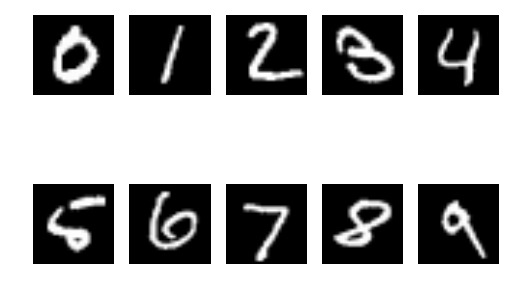

In [9]:
nb_adv_per_sample = str(nb_classes - 1)
print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample + ' adversarial examples')
###########################################################################

assert source_samples == nb_classes
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]
# [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
# Pick the first appearances of the 9 numbers in X_test
for i,idx in enumerate(idxs):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,:,:,0],cmap='gray')
    plt.axis('off')


# Create adv samples using the Carlini-L2 attack:

In [14]:
# Form a 10 x 10 array of the inputs that you seek to target:
adv_inputs = np.array([[instance] * nb_classes for instance in X_test[idxs]],dtype=np.float32)
adv_inputs = adv_inputs.reshape((source_samples * nb_classes, img_rows, img_cols, 1))


one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1



adv_ys = np.array([one_hot] * source_samples,dtype=np.float32).reshape((source_samples * nb_classes, nb_classes))
# yname = "y_target"
# Instantiate a CW attack object
# model_wrap = KerasModelWrapper(model)
cw = CarliniWagnerL2(model, back='tf', sess=sess)
cw_params = {'binary_search_steps': 15,
             'y_target': adv_ys,
             'max_iterations': 50000,
             'learning_rate': 1,
             'batch_size': source_samples * nb_classes if
             targeted else source_samples,
             'initial_const': 0.1,
            'verbose':False}

adv = cw.generate_np(adv_inputs, **cw_params)

[INFO 2017-11-03 11:24:06,239 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2017-11-03 11:24:06,591 cleverhans] Running CWL2 attack on instance 0 of 100
[DEBUG 2017-11-03 11:24:06,607 cleverhans]   Binary search step 0 of 15
[DEBUG 2017-11-03 11:24:06,656 cleverhans]     Iteration 0 of 50000: loss=8.98 l2=0 f=0.1
[DEBUG 2017-11-03 11:24:35,039 cleverhans]     Iteration 5000 of 50000: loss=9.78 l2=0.00807 f=0.1
[DEBUG 2017-11-03 11:24:35,039 cleverhans]     Failed to make progress; stop early
[DEBUG 2017-11-03 11:24:35,041 cleverhans]   Successfully generated adversarial examples on 12 of 100 instances.
[DEBUG 2017-11-03 11:24:35,042 cleverhans]    Mean successful distortion: 0.5183
[DEBUG 2017-11-03 11:24:35,043 cleverhans]   Binary search step 1 of 15
[DEBUG 2017-11-03 11:24:35,048 cleverhans]     Iteration 0 of 50000: loss=87.9 l2=0 f=0.1
[DEBUG 2017-11-03 11:25:04,936 cleverhans]     Iteration 5000 of 50000: loss=89.2 l2=0.0126 f=0.1
[DEBUG 2017-11-03 11:25:04

# Now, how good were these adv examples?

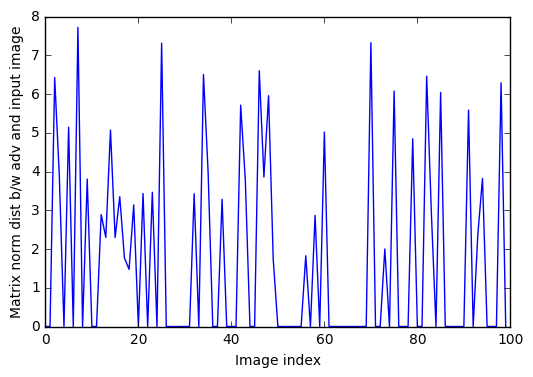

In [15]:
dev=np.zeros(100)
for i in range(100):
    dev[i]=np.linalg.norm(np.abs(adv[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [16]:
eval_params = {'batch_size': np.minimum(nb_classes, source_samples)}
adv_accuracy = model_eval(sess, x, y, preds, adv, adv_ys, args=eval_params)

# Initialize our array for grid visualization
grid_shape = (nb_classes, nb_classes, img_rows, img_cols, channels)
grid_viz_data = np.zeros(grid_shape, dtype='f')

for j in range(nb_classes):
    for i in range(nb_classes):
        grid_viz_data[i, j] = adv[i * nb_classes + j]


print(grid_viz_data.shape)

print('--------------------------------------')

# Compute the number of adversarial examples that were successfully found
print('Avg. rate of successful adv. examples {0:.4f}'.format(adv_accuracy))
report.clean_train_adv_eval = 1. - adv_accuracy

# Compute the average distortion introduced by the algorithm
percent_perturbed = np.mean(np.sum((adv - adv_inputs)**2,
                                   axis=(1, 2, 3))**.5)
print('Avg. L_2 norm of perturbations {0:.4f}'.format(percent_perturbed))



(10, 10, 28, 28, 1)
--------------------------------------
Avg. rate of successful adv. examples 0.5000
Avg. L_2 norm of perturbations 1.7176


In [17]:
report.__dict__

{'adv_train_adv_eval': 0.0,
 'adv_train_clean_eval': 0.0,
 'clean_train_adv_eval': 0.4999999925494194,
 'clean_train_clean_eval': 0.98750000000000004,
 'train_adv_train_adv_eval': 0.0,
 'train_adv_train_clean_eval': 0.0,
 'train_clean_train_adv_eval': 0.0,
 'train_clean_train_clean_eval': 0.0}

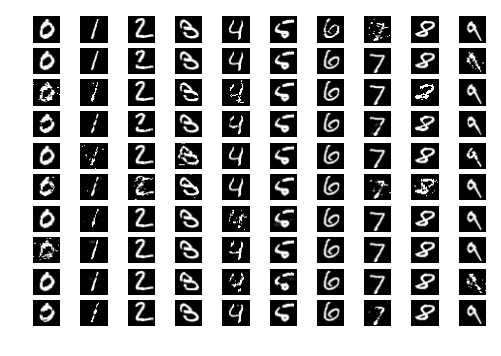

In [18]:
# Finally, block & display a grid of all the adversarial examples
_ = grid_visual(grid_viz_data)